In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('simulation_results_finished.csv')
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
df.set_index('Date', inplace=True)
outdoor_temp_series = df['Dry-bulb temperature (°C)']
outdoor_temp_series = outdoor_temp_series.to_frame().reset_index()

# Convert time to seconds for simulation alignment instead of half-hourly intervals
outdoor_temp_series["time_seconds"] = (outdoor_temp_series["Date"] - outdoor_temp_series["Date"].iloc[0]).dt.total_seconds()

In [3]:
# Define constants
heater_power = 2000  # Heater power in watts (W)
room_volume = 60*3     # Room volume in cubic meters (m³)
air_density = 1.225  # Air density in kg/m³
specific_heat_air = 1005  # Specific heat of air in J/(kg·K)
heat_loss_rate = 50  # Heat loss rate to environment in W/K (depends on insulation)
initial_room_temp = 20  # Initial room temperature in °C
thermostat_temp = 20  # Thermostat set temperature in °C
hysteresis = 2.0  # Thermostat hysteresis in °C
simulation_time = 365 * 24 * 3600  # Simulation time for one year (in seconds)
time_step = 1  # Time step in seconds
air_mass_flow_rate = 0.1  # Air mass flow rate in kg/s

# Derived constants
air_mass = room_volume * air_density  # Total air mass in the room (kg)

# Simulation variables
time = np.arange(0, simulation_time, time_step)  # Time array for one year
room_temp = np.zeros_like(time, dtype=float)  # Room temperature array
heater_status = np.zeros_like(time, dtype=int)  # Heater status array (1=ON, 0=OFF)
heater_temp = np.zeros_like(time, dtype=float)  # Heater temperature array

# Interpolate outdoor temperature for simulation time steps
outdoor_temp = np.interp(time, outdoor_temp_series["time_seconds"], outdoor_temp_series['Dry-bulb temperature (°C)'])

# Initialize room temperature
room_temp[0] = initial_room_temp

# Simulation loop
for t in range(1, len(time)):
    # Calculate heat losses
    heat_loss = heat_loss_rate * (room_temp[t-1] - outdoor_temp[t])
    
    # Determine heater status based on thermostat control
    if room_temp[t-1] < thermostat_temp - hysteresis / 2:
        heater_status[t] = 1  # Heater ON
    elif room_temp[t-1] > thermostat_temp + hysteresis / 2:
        heater_status[t] = 0  # Heater OFF
    else:
        heater_status[t] = heater_status[t-1]  # Maintain previous state

    # Calculate heat gain from heater
    heat_gain = heater_status[t] * heater_power
    
    # Calculate heater temperature
    heater_temp[t-1] = room_temp[t-1] + heat_gain / (air_mass_flow_rate * specific_heat_air)

    # Calculate net heat change
    net_heat = heat_gain - heat_loss

    # Update room temperature
    temp_change = (net_heat * time_step) / (air_mass * specific_heat_air)
    room_temp[t] = room_temp[t-1] + temp_change

# Calculate heater runtime and energy usage
heater_runtime = np.sum(heater_status) * time_step / 3600  # Hours
energy_usage = heater_runtime * heater_power / 1000  # kWh


Heater runtime: 2606.31 hours
Total energy usage: 5212.62 kWh


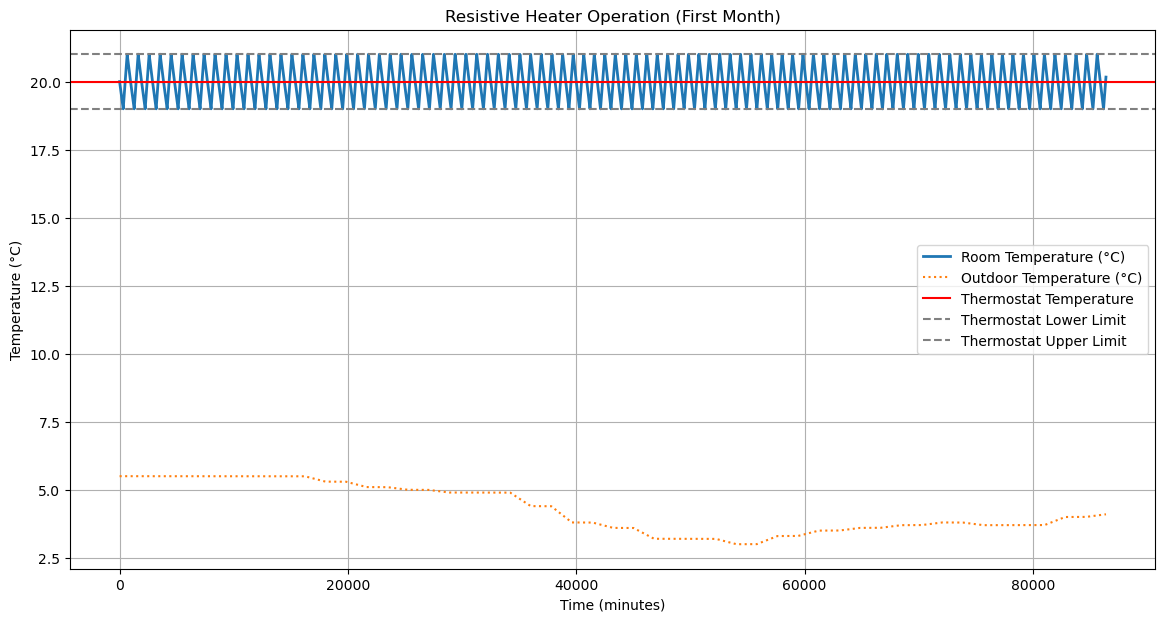

In [6]:
# Display results
print(f"Heater runtime: {heater_runtime:.2f} hours")
print(f"Total energy usage: {energy_usage:.2f} kWh")

# Plot results for the first month (example visualization)
plt.figure(figsize=(14, 7))

# Plot room temperature
plt.plot(time[:43200*2], room_temp[:43200*2], label="Room Temperature (°C)", linewidth=2)

# Plot outdoor temperature
plt.plot(time[:43200*2], outdoor_temp[:43200*2], label="Outdoor Temperature (°C)", linestyle=":")

# Add thermostat bounds
plt.axhline(y=thermostat_temp, color="r", linestyle="-", label="Thermostat Temperature")
plt.axhline(y=thermostat_temp - hysteresis / 2, color="gray", linestyle="--", label="Thermostat Lower Limit")
plt.axhline(y=thermostat_temp + hysteresis / 2, color="gray", linestyle="--", label="Thermostat Upper Limit")

plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Resistive Heater Operation (First Month)")
plt.legend()
plt.grid()
plt.show()